In [64]:
# import libraries
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [65]:
# import electricity dataset
electricity_data = pd.read_csv('../data/daily_dataset.csv')

In [66]:
# group the dataset by day, getting the average household energy consumption, and the count of houses sampled each day
electricity_grouped = electricity_data.groupby('day').agg({'energy_sum': 'mean', 'LCLid': 'count'}).reset_index()
electricity_grouped = electricity_grouped.rename(columns={'energy_sum': 'energy_avg', 'LCLid': 'num_samples'})

In [67]:
electricity_grouped.head(5)

,day,energy_avg,num_samples
0,2011-11-23,6.952692,13
1,2011-11-24,8.536480,25
2,2011-11-25,9.499781,32
3,2011-11-26,10.267707,41
4,2011-11-27,10.850805,41


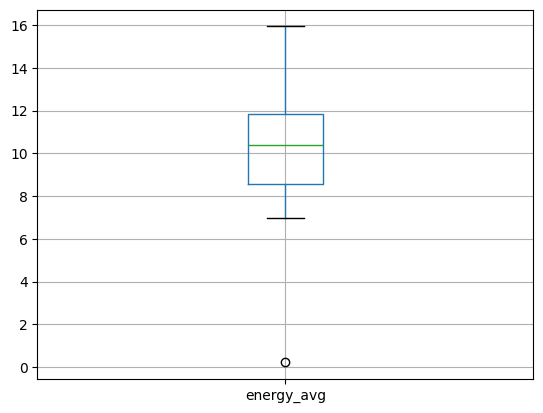

In [68]:
electricity_grouped.boxplot('energy_avg')
plt.show()

In [69]:
# filter out the outlier 
electricity_grouped = electricity_grouped[electricity_grouped['energy_avg'] > 1]

In [70]:
# import weather data
weather_data = pd.read_csv('../data/weather_daily_darksky.csv')

In [71]:
weather_data.head(5)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [72]:
# create day column for linking 
weather_data['day'] = weather_data['time'].str[:10]

In [73]:
# link weather data onto electricity data
full_data = pd.merge(electricity_grouped, weather_data, on='day')

In [74]:
# drop NaN values 
full_data = full_data.dropna()

In [75]:
# split into features and target 
X = full_data[['temperatureMax', 'windBearing',
       'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity', 
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex']]  # Features: Weather conditions
y = full_data['energy_avg']    # Target variable: Mean energy consumption

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Create a Random Forest regression model
rf_model = RandomForestRegressor()

In [78]:
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [79]:
# Fit the model to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [80]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [81]:
# Make predictions on the test set using the best model
y_pred_rf_best = grid_search.best_estimator_.predict(X_test)

In [82]:
# Evaluate the model with the best parameters
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
print(mse_rf_best)
print(mae_rf_best)
print(r2_rf_best)

0.5780110125575478
0.5447737109443582
0.8434066515226506


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


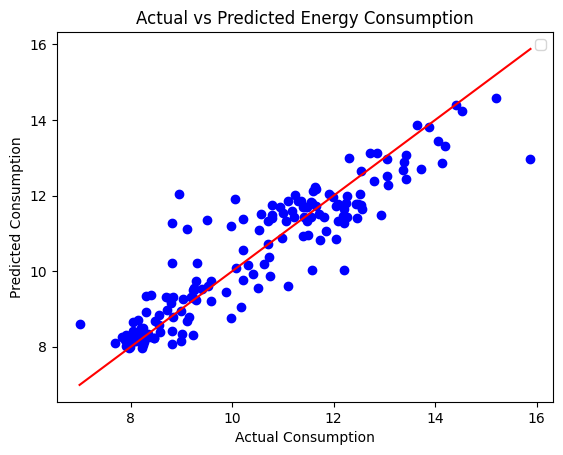

In [83]:
# Visualize the results
plt.scatter(y_test, y_pred_rf_best, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.legend()
plt.show()